# **Covid-19 Dataset**
## **Data Pre-Processing**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [ ]:
df = pd.read_csv('covid_train.csv')

### Checking data for preprocessing
##### Note:
 - Normalization is not important for DTs, RFs, and GBTs since the splitting rules are not dependent on the scaling of the data.
 - Feature selection is also not important for DTs, RFs, and GBTs because during the induction of decision trees, the optimal feature is selected to split the data based on metrics like information gain
 - Removing/replacing missing values would be considered.
 - We will not consider outlier removal because most of features are categorical or ordinal, except latitude and longitude where assumed outliers could contain important information about specific locations.
 - Encoding for categorical data must be applied.

In [ ]:
df.head()

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,50s,MALE,NO KNOWN EPI LINK,Oakville,NaN,43.413997,-79.744796,Resolved
1,20s,FEMALE,CC,Guelph,NaN,43.524881,-80.233743,Not Resolved
2,90s,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,Resolved
3,20s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358,Resolved
4,90s,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,Fatal


In [ ]:
df.describe()

,Reporting_PHU_Latitude,Reporting_PHU_Longitude
count,14851.000000,14851.000000
mean,43.741457,-79.565291
std,0.752952,1.589850
min,42.308796,-94.488254
25%,43.647471,-79.708893
50%,43.656591,-79.379358
75%,43.656591,-79.379358
max,49.769615,-74.736298


In [ ]:
df.shape

(14851, 8)

In [ ]:
df.nunique(axis=0) 

Age_Group                   9
Client_Gender               4
Case_AcquisitionInfo        6
Reporting_PHU_City         34
Outbreak_Related            1
Reporting_PHU_Latitude     34
Reporting_PHU_Longitude    34
Outcome1                    3
dtype: int64

### Clean data: drop NaN

##### Note:
 - The unspecified values in features 'Client_Gender' and 'Case_AcquisitionInfo' are treated as missing values NaN; since the number of these missing values are relatively small, they are considered as outliers too.
 - NaN in feature 'Outbreak_Related' are not missing values, and they mean 'No'.

In [ ]:
df_clean = df.copy()
df_clean['Client_Gender'] = df_clean['Client_Gender'] \
  .replace(['UNSPECIFIED'],np.nan)
df_clean['Case_AcquisitionInfo'] = df_clean['Case_AcquisitionInfo'] \
  .replace(['UNSPECIFIED EPI LINK'],np.nan)
df_clean['Outbreak_Related'] = df_clean['Outbreak_Related'].fillna('No')

In [ ]:
stats = pd.DataFrame(index=df_clean.columns)
stats['# NaN'] = df_clean.isnull().sum()
stats['count'] = df_clean.count()
print("Before removal:")
print(stats)

Before removal:
                         # NaN  count
Age_Group                    6  14845
Client_Gender              107  14744
Case_AcquisitionInfo         4  14847
Reporting_PHU_City           0  14851
Outbreak_Related             0  14851
Reporting_PHU_Latitude       0  14851
Reporting_PHU_Longitude      0  14851
Outcome1                     0  14851


In [ ]:
df_clean.dropna(inplace=True)

In [ ]:
stats = pd.DataFrame(index=df_clean.columns)
stats['# NaN'] = df_clean.isnull().sum()
stats['count'] = df_clean.count()
print("After removal:")
print(stats)

After removal:
                         # NaN  count
Age_Group                    0  14737
Client_Gender                0  14737
Case_AcquisitionInfo         0  14737
Reporting_PHU_City           0  14737
Outbreak_Related             0  14737
Reporting_PHU_Latitude       0  14737
Reporting_PHU_Longitude      0  14737
Outcome1                     0  14737


### Preprocess data: encoding categorical and ordinal features

In [ ]:
df_encoded = pd.DataFrame()

In [ ]:
# Age_Group
age_group_encoding = {'<20':0, '20s':20, '30s':30, '40s':40, '50s':50, \
                      '60s':60, '70s':70, '80s':80, '90s':90}
df_encoded['Age_Group'] = df_clean['Age_Group'].replace(age_group_encoding)

In [ ]:
# Client_Gender: one-hot encoding
encoding_df = pd.get_dummies(df_clean['Client_Gender'], \
                             columns=["Client_Gender"], prefix="Gender")
df_encoded = df_encoded.join(encoding_df)

In [ ]:
# Case_AcquisitionInfo: one-hot encoding
encoding_df = pd.get_dummies(df_clean['Case_AcquisitionInfo'], \
                             columns=["Case_AcquisitionInfo"], prefix="Case")
df_encoded = df_encoded.join(encoding_df)

In [ ]:
# Outbreak_Related
df_encoded['Outbreak_Related'] = df_clean['Outbreak_Related'] \
  .map(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# Reporting_PHU_Latitude
df_encoded['Reporting_PHU_Latitude'] = df_clean['Reporting_PHU_Latitude']
# Reporting_PHU_Longitude
df_encoded['Reporting_PHU_Longitude'] = df_clean['Reporting_PHU_Longitude']

In [ ]:
# Reporting_PHU_City: one-hot encoding
encoding_df = pd.get_dummies(df_clean['Reporting_PHU_City'], \
                             columns=["Reporting_PHU_City"], prefix="City")
df_encoded = df_encoded.join(encoding_df)

In [ ]:
# Outcome1
df_encoded['Outcome1'] = df_clean['Outcome1']

In [ ]:
df_encoded.head()

,Age_Group,Gender_FEMALE,Gender_GENDER DIVERSE,Gender_MALE,Case_CC,Case_MISSING INFORMATION,Case_NO KNOWN EPI LINK,Case_OB,Case_TRAVEL,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,City_Barrie,City_Belleville,City_Brantford,City_Brockville,City_Chatham,City_Cornwall,City_Guelph,City_Hamilton,City_Kenora,City_Kingston,City_London,City_Mississauga,City_New Liskeard,City_Newmarket,City_North Bay,City_Oakville,City_Ottawa,City_Owen Sound,City_Pembroke,City_Peterborough,City_Point Edward,City_Port Hope,City_Sault Ste. Marie,City_Simcoe,City_St. Thomas,City_Stratford,City_Sudbury,City_Thorold,City_Thunder Bay,City_Timmins,City_Toronto,City_Waterloo,City_Whitby,City_Windsor,Outcome1
0,50,0,0,1,0,0,1,0,0,0,43.413997,-79.744796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Resolved
1,20,1,0,0,1,0,0,0,0,0,43.524881,-80.233743,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Not Resolved
2,90,1,0,0,0,0,0,1,0,1,44.410713,-79.686306,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Resolved
3,20,1,0,0,0,1,0,0,0,0,43.656591,-79.379358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Resolved
4,90,1,0,0,0,0,0,1,0,1,45.345665,-75.763912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fatal


# **Tree-based Classifiers and Ensembles**


References:
*   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
*   https://scikit-learn.org/stable/modules/grid_search.html

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import tree

In [ ]:
X = df_encoded[df_encoded.columns[:-1]]
y = df_encoded['Outcome1']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 20% test

## **Decision Tree**
*   Max depth: {3, 5, 10, None}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
max_depth = [3, 5, 10, None]
parameters = {'max_depth': max_depth, 'random_state': [0]}

In [ ]:
dtc = DecisionTreeClassifier()
clf = GridSearchCV(estimator=dtc, param_grid=parameters, cv=10)
clf.fit(X_train, y_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.64840114 0.65671435 0.65883436 0.64543223]


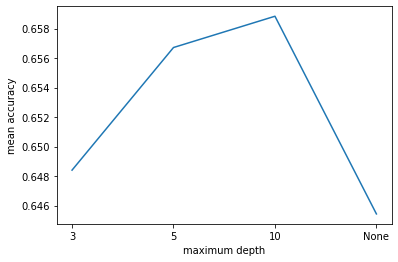

In [ ]:
plt.plot(max_depth[:-1]+['None'], accuracy)
plt.xlabel('maximum depth')
plt.ylabel('mean accuracy')
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'max_depth': 10}


### Evaluate Performance on Test Dataset

In [ ]:
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
dt_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",dt_accuracy)

Accuracy: 0.6709633649932157


In [ ]:
algo = []
score = []
algo.append('DT')
score.append(dt_accuracy)

### Examine the final resulting splitting rules used for the trees:
##### Note:
Leaf nodes at depth beyond 3 are not visible on the graph, so the maximum depth is limited to 3.

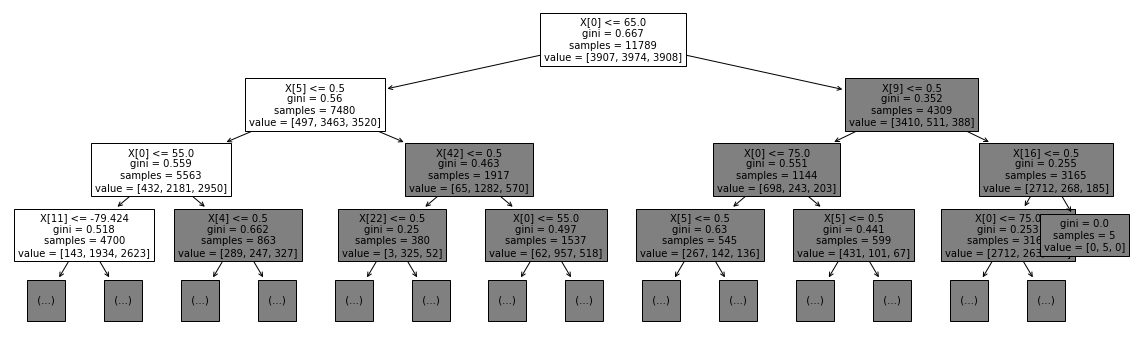

In [ ]:
plt.figure(figsize=[20,6])
tree.plot_tree(clf, max_depth=3, fontsize=10)
plt.show()

##### **Splitting Rules**
- Decision trees use multiple algorithms to decide to split a node in two or more sub-nodes. The creation of sub-nodes increases the homogeneity of resultant sub-nodes. In other words, we can say that purity of the node increases with respect to the target variable. Decision tree splits the nodes on all available variables and then selects the split which results in most homogeneous sub-nodes.
- Impurity is a measure of the homogeneity of the labels on a node. There are many ways to implement the impurity measure, two of which scikit-learn has implemented is the Information gain and Gini Impurity / Gini Index.
- Information gain uses the entropy measure as the impurity measure and splits a node such that it gives the most amount of information gain. Whereas Gini Impurity measures the divergences between the probability distributions of the target attribute’s values and splits a node such that it gives the least amount of impurity.

##### **Comments for our model and the dataset**
- In our model we use the the default parameters for the decision tree classifier except the maximum depth, so in this case, splitting depends on the Gini Index.
- The number of samples (training set) is 11798.
- The root node is splitted at feature x[0] (Age_Group) <= 65 (i.e. people in their 20s to 60s on LHS, and people in their 70s to 90s on RHS). For the old age group (Age_Group > 65) on RHS, the majority of the samples is in target class 'Fatal' at 3410/4309, indicating that Age_Group is a very important feature to determine target 'Fatal'.
- The young age group (Age_Group <= 65) at depth = 1 on LHS is splitted at feature x[5] (Case_MISSING INFORMATION) <= 0.5 (i.e. Case_AcquisitionInfo is not MISSING INFORMATION on LHS, and Case_AcquisitionInfo is MISSING INFORMATION on RHS). For Case_AcquisitionInfo is MISSING INFORMATION on RHS, a large portion of the samples is in target class 'Not Resolved' at 1282/1917, indicating that Case_AcquisitionInfo is important for determining target 'Not Resolved'.
- For the first pure leaf node at depth = 3 on the very right side, the splitting rules included Age_Group > 65, Outbreak_Related = 1, City_Chatham = 1, meaning that for people in their 70s to 90s, if it is related to outbreak, in the city of Chatham, target is 'Not Resolved'.
- At lower levels (like depth = 2 and 3), there are leaf nodes with higher Gini index but small portion of samples from their parent nodes.
- In overall, based on the performance in reducing gini score on large number of samples, some noticably important features in the splitting rules include Age_Group, Case_AcquisitionInfo, and Outbreak_Related; Reporting_PHU_Longitude and Reporting_PHU_City may be important too.


## **Random Forest**
*   Number of trees: {5, 10, 50, 150, 200}
*   Max depth: {3, 5, 10, None}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
number_of_trees = [5, 10, 50, 150, 200]
max_depth = [3, 5, 10, None]
parameters = {'n_estimators': number_of_trees, 'max_depth': max_depth, \
              'random_state': [0]}

In [ ]:
rfc = RandomForestClassifier()
clf = GridSearchCV(estimator=rfc, param_grid=parameters, cv=10)
clf.fit(X_train, y_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.59029709 0.62202033 0.6202388  0.61786405 0.6165069  0.63372682
 0.63703644 0.63211449 0.64322683 0.64212391 0.65807143 0.65722354
 0.66349961 0.66434779 0.66409319 0.64415946 0.64628012 0.64746807
 0.64840121 0.64780734]


In [ ]:
accuracy_df = pd.DataFrame(data=np.reshape(accuracy, (-1, 5)), \
                           index=max_depth[:-1]+['None'], \
                           columns=number_of_trees)
print(accuracy_df)

           5         10        50        150       200
3     0.590297  0.622020  0.620239  0.617864  0.616507
5     0.633727  0.637036  0.632114  0.643227  0.642124
10    0.658071  0.657224  0.663500  0.664348  0.664093
None  0.644159  0.646280  0.647468  0.648401  0.647807


### Heat plot: (5 * 4) mean accuracies for different values of number of trees and maximum depth

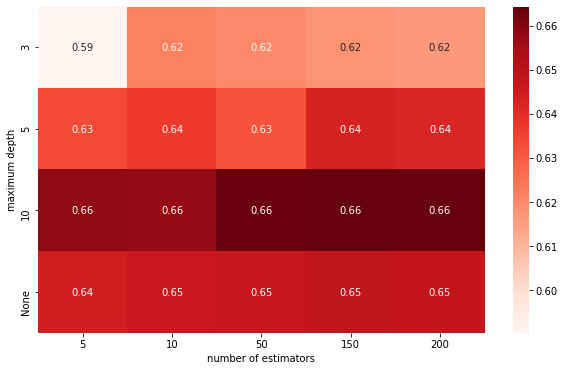

In [ ]:
plt.figure(figsize=(10,6))
seaborn.heatmap(accuracy_df, annot=True, cmap=plt.cm.Reds)
plt.xlabel('number of estimators') 
plt.ylabel('maximum depth') 
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'max_depth': 10, 'n_estimators': 150}


In [ ]:
clf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",rf_accuracy)

Accuracy: 0.6818181818181818


In [ ]:
algo.append('RF')
score.append(rf_accuracy)

## **Gradient Tree Boosting**
*   Number of estimators: {5, 10, 50, 150, 200}

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
number_of_estimators = [5, 10, 50, 150, 200]
parameteres = {'n_estimators': number_of_estimators, 'random_state': [0]}

In [ ]:
gbc = GradientBoostingClassifier()
clf = GridSearchCV(estimator=gbc, param_grid=parameteres, cv=10)
clf.fit(X_train, y_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.65170852 0.65764691 0.66536517 0.66621371 0.66612867]


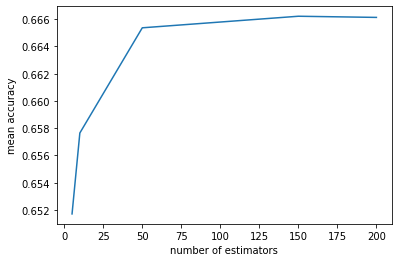

In [ ]:
plt.plot(number_of_estimators,accuracy)
plt.xlabel('number of estimators')
plt.ylabel('mean accuracy')
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'n_estimators': 150}


In [ ]:
clf = GradientBoostingClassifier(n_estimators=150, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
gbt_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",gbt_accuracy)

Accuracy: 0.6855495251017639


In [ ]:
algo.append('GBT')
score.append(gbt_accuracy)

# **Performance Comparison**

### Decision Tree
*   max_depth = 10

### Random Forest
*   number of trees = 150
*   max depth = 10

### Gradient Tree Boosting
*   number of estimators = 150

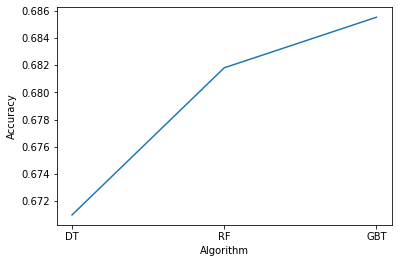

In [ ]:
plt.plot(algo, score)
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.show()

#### **General Comments**
- Random forest will reduce variance part of error rather than bias part, so on a given training data set, decision tree may be more accurate than a random forest. But on an unexpected validation data set, random forest always wins in terms of accuracy.

- Boosting is based on weak learners (high bias, low variance). In terms of decision trees, weak learners are shallow trees, sometimes even as small as decision stumps (trees with two leaves). Boosting reduces error mainly by reducing bias (and also to some extent variance, by aggregating the output from many models).

- On the other hand, random forest uses fully grown decision trees (low bias, high variance). It tackles the error reduction task in the opposite way: by reducing variance. The trees are made uncorrelated to maximize the decrease in variance, but the algorithm cannot reduce bias.

#### **Comments from our results**
- RF has better accuracy than DT, as a result of its ability to reduce variance compared to DT
- GBT yielded better accuracy than other models as a result of its ability to reduce bias.